In [2]:
# TBD 2: flask github 참고, method, class, 파일의 맨 윗단 마다 pydoc 형식으로 달기
# TBD 3: 축약어를 자제할것 (특히 변수)

# tensorflow Module
import tensorflow as tf
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.callbacks import ReduceLROnPlateau
# external Module
import numpy as np
import segmentation_models as sm

# basic Module
import os
from datetime import datetime
from glob import glob

from gan_module.data_loader.segmentation import SegDataloader
from gan_module.util import custom_loss
from gan_module.util.custom_loss import WeightedRegionLoss, TverskyLoss, dice_score, dice_loss
from gan_module.config import CONFIG


custom_loss.AXIS = [1, 2]
USE_GPU = True
# set GPU memory growth allocation
if USE_GPU :
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    gpu_devices = tf.config.experimental.list_physical_devices("GPU")
    for device in gpu_devices:
        tf.config.experimental.set_memory_growth(device, True)
else:
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
    gpu_devices = tf.config.experimental.list_physical_devices("CPU")

print(gpu_devices)

BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)


class UnetSegmentation:
    def __init__(
        self,
        dataset_name,
        generator_learning_rate=1e-4,
    ):

        img_shape = CONFIG["img_shape"]
        input_channels = CONFIG["input_channels"]
        output_channels = CONFIG["output_channels"]

        # Configure data loader
        train_image_path_list = glob(
            f"./datasets/{dataset_name}/train/image/*.png")
        train_mask_path_list = glob(
            f"./datasets/{dataset_name}/train/mask/*.png")
        valid_image_path_list = glob(
            f"./datasets/{dataset_name}/valid/image/*.png")
        valid_mask_path_list = glob(
            f"./datasets/{dataset_name}/valid/mask/*.png")

        self.train_data_loader = SegDataloader(
            image_path_list=train_image_path_list,
            mask_path_list=train_mask_path_list,
            batch_size=4,
            shuffle=True,
            backbone=BACKBONE,
        )
        self.valid_data_loader = SegDataloader(
            image_path_list=valid_image_path_list,
            mask_path_list=valid_mask_path_list,
            batch_size=4,
            shuffle=True,
            backbone=BACKBONE,
        )
        # Number of filters in the first layer of G and D
        self.generator_learning_rate = generator_learning_rate
        generator_optimizer = Nadam(self.generator_learning_rate, clipnorm=1)

        self.generator = sm.Unet(backbone_name=BACKBONE, input_shape=(
            None, None, input_channels), classes=output_channels, activation='sigmoid')
        # loss = sm.losses.bce_dice_loss
        self.generator.compile(
            loss=sm.losses.JaccardLoss(per_image=True),
            optimizer=generator_optimizer,
            metrics=[dice_score],
        )

    def train(self, epochs, batch_size=4, start_epoch=0):

        start_time = datetime.now()
        self.train_data_loader.batch_size = batch_size
        self.valid_data_loader.batch_size = batch_size

        save_c = ModelCheckpoint(
            "./U_net/weights_{epoch:02d}_{loss:.4f}.hdf5",
            monitor='val_loss',
            verbose=0,
            save_best_only=False,
            save_weights_only=True,
            mode='min')

        reduceLROnPlat = ReduceLROnPlateau(
            monitor="val_loss",
            factor=0.1,
            patience=10,
            verbose=1,
            mode="auto",
            min_delta=0.0001,
            cooldown=5,
            min_lr=1e-9)
        csv_logger = CSVLogger('./U_net/log.csv', append=False, separator=',')

        self.generator.fit(
            self.train_data_loader,
            validation_data=self.valid_data_loader,
            batch_size=batch_size,
            epochs=epochs,
            callbacks=[reduceLROnPlat, save_c, csv_logger],
            initial_epoch=start_epoch
        )

        elapsed_time = datetime.now() - start_time
        print(f"elapsed_time : {elapsed_time}")


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
generator_lr = 1e-4
dataset_name = "glomerulus_0.65_512_remove_peel_split_man"
batch_size = 4
g_lr = generator_lr * batch_size
gan = UnetSegmentation(dataset_name=dataset_name, generator_learning_rate=g_lr)

In [ ]:
#gan.find_error = True
gan.generator.load_weights("./U_net/weights_98_0.1090.hdf5")
gan.train(epochs=325, batch_size=batch_size, start_epoch=98)

Epoch 99/325
1125/1125 [==============================] - 308s 260ms/step - loss: 0.1914 - dice_score: 0.8302 - val_loss: 0.3267 - val_dice_score: 0.7315
Epoch 100/325
1125/1125 [==============================] - 292s 259ms/step - loss: 0.1987 - dice_score: 0.8239 - val_loss: 0.1326 - val_dice_score: 0.8908
Epoch 101/325
1125/1125 [==============================] - 291s 259ms/step - loss: 0.2125 - dice_score: 0.8105 - val_loss: 0.0864 - val_dice_score: 0.9347
Epoch 102/325
1125/1125 [==============================] - 288s 256ms/step - loss: 0.1889 - dice_score: 0.8371 - val_loss: 0.3855 - val_dice_score: 0.6582
Epoch 103/325
1125/1125 [==============================] - 291s 259ms/step - loss: 0.1528 - dice_score: 0.8699 - val_loss: 0.1752 - val_dice_score: 0.8497
Epoch 104/325
1125/1125 [==============================] - 287s 255ms/step - loss: 0.1692 - dice_score: 0.8542 - val_loss: 0.0908 - val_dice_score: 0.9316
Epoch 105/325
1125/1125 [==============================] - 285s 253ms/s

In [4]:
temp = gan.train_data_loader[0]

In [5]:
gan.generator.train_on_batch(temp[0],temp[1])

[0.17262513935565948, 0.21200449764728546]

In [6]:
a = gan.generator.predict_on_batch(temp[0])

In [7]:
from tensorflow.keras import backend as K

In [8]:
WeightedRegionLoss()(K.constant(a), K.constant(temp[1]))

<tf.Tensor: shape=(), dtype=float32, numpy=0.85738504>

In [9]:
y_true = K.constant(a)
y_pred = K.constant(temp[1])

beta = 0.7
alpha = 1 - beta
AXIS=[1,2,3]
smooth = K.epsilon()
tp = K.sum(y_true * y_pred, axis=AXIS)
tn = K.sum((1 - y_true) * (1 - y_pred), axis=AXIS)
fp = K.sum(y_pred, axis=AXIS) - tp
fn = K.sum(y_true, axis=AXIS) - tp

postive_ratio = K.mean(y_true, axis=AXIS)

negative_score = (tn + smooth) \
    / (tn + beta * fn + alpha * fp + smooth) * (smooth + 1 - postive_ratio)
positive_score = (tp + smooth) \
    / (tp + alpha * fn + beta * fp + smooth) * (smooth + postive_ratio)
total_score = (negative_score + positive_score)

In [10]:
tp

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([9241.069,    0.   ,    0.   ,    0.   ], dtype=float32)>

In [11]:
tn

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([74873.13 , 76256.73 , 81890.75 , 82729.875], dtype=float32)>

In [12]:
postive_ratio

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.6968343, 0.7091036, 0.6876116, 0.6844106], dtype=float32)>

In [13]:
total_score

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.21469457, 0.10748646, 0.12294888, 0.12532985], dtype=float32)>

In [14]:
negative_score

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.11484194, 0.10748646, 0.12294888, 0.12532985], dtype=float32)>

In [15]:
positive_score

<tf.Tensor: shape=(4,), dtype=float32, numpy=
array([9.9852636e-02, 1.2715660e-12, 1.2715659e-12, 1.2715660e-12],
      dtype=float32)>

In [16]:
1 - postive_ratio

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.9985988 , 0.99861276, 0.99861807, 0.99862623], dtype=float32)>

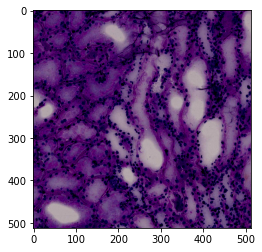

In [10]:
from matplotlib import pyplot as plt

plt.imshow(temp[0])

In [8]:
temp[1].shape

(512, 512, 3)

In [12]:
gan.train_data_loader.data_getter.mask_path_list

['./datasets/glomerulus_0.65_512_remove_peel_split_man/train/mask\\afa5e8098_2246.png',
 './datasets/glomerulus_0.65_512_remove_peel_split_man/train/mask\\095bf7a1f_2670.png',
 './datasets/glomerulus_0.65_512_remove_peel_split_man/train/mask\\cb2d976f4_2621.png',
 './datasets/glomerulus_0.65_512_remove_peel_split_man/train/mask\\54f2eec69_3356.png',
 './datasets/glomerulus_0.65_512_remove_peel_split_man/train/mask\\c68fe75ea_3111.png',
 './datasets/glomerulus_0.65_512_remove_peel_split_man/train/mask\\2f6ecfcdf_3676.png',
 './datasets/glomerulus_0.65_512_remove_peel_split_man/train/mask\\cb2d976f4_3050.png',
 './datasets/glomerulus_0.65_512_remove_peel_split_man/train/mask\\54f2eec69_3413.png',
 './datasets/glomerulus_0.65_512_remove_peel_split_man/train/mask\\c68fe75ea_400.png',
 './datasets/glomerulus_0.65_512_remove_peel_split_man/train/mask\\cb2d976f4_2165.png',
 './datasets/glomerulus_0.65_512_remove_peel_split_man/train/mask\\b9a3865fc_923.png',
 './datasets/glomerulus_0.65_512_r

In [14]:
gan.train_data_loader.data_getter[0]

(array([[[ 0.40392157,  0.09803922,  0.52156863],
         [ 0.30196078,  0.00392157,  0.35686275],
         [ 0.37254902,  0.09803922,  0.42745098],
         ...,
         [ 0.56078431,  0.46666667,  0.57647059],
         [ 0.57647059,  0.48235294,  0.59215686],
         [ 0.57647059,  0.48235294,  0.59215686]],
 
        [[ 0.2627451 , -0.01960784,  0.38039216],
         [ 0.3254902 ,  0.05882353,  0.38039216],
         [ 0.41176471,  0.14509804,  0.45882353],
         ...,
         [ 0.57647059,  0.48235294,  0.59215686],
         [ 0.59215686,  0.49803922,  0.60784314],
         [ 0.58431373,  0.49803922,  0.6       ]],
 
        [[ 0.42745098,  0.16078431,  0.5372549 ],
         [ 0.38823529,  0.14509804,  0.48235294],
         [ 0.39607843,  0.11372549,  0.4745098 ],
         ...,
         [ 0.59215686,  0.49803922,  0.60784314],
         [ 0.59215686,  0.49803922,  0.60784314],
         [ 0.60784314,  0.51372549,  0.62352941]],
 
        ...,
 
        [[ 0.33333333,  0.04313725

In [19]:
temp

array([[[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]],


       [[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
 

In [13]:
gan.train_data_loader.data_getter.image_path_list

['./datasets/glomerulus_0.65_512_remove_peel_split_man/train/image\\afa5e8098_2246.png',
 './datasets/glomerulus_0.65_512_remove_peel_split_man/train/image\\095bf7a1f_2670.png',
 './datasets/glomerulus_0.65_512_remove_peel_split_man/train/image\\cb2d976f4_2621.png',
 './datasets/glomerulus_0.65_512_remove_peel_split_man/train/image\\54f2eec69_3356.png',
 './datasets/glomerulus_0.65_512_remove_peel_split_man/train/image\\c68fe75ea_3111.png',
 './datasets/glomerulus_0.65_512_remove_peel_split_man/train/image\\2f6ecfcdf_3676.png',
 './datasets/glomerulus_0.65_512_remove_peel_split_man/train/image\\cb2d976f4_3050.png',
 './datasets/glomerulus_0.65_512_remove_peel_split_man/train/image\\54f2eec69_3413.png',
 './datasets/glomerulus_0.65_512_remove_peel_split_man/train/image\\c68fe75ea_400.png',
 './datasets/glomerulus_0.65_512_remove_peel_split_man/train/image\\cb2d976f4_2165.png',
 './datasets/glomerulus_0.65_512_remove_peel_split_man/train/image\\b9a3865fc_923.png',
 './datasets/glomerulus

In [2]:
temp.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 512, 512, 4)  0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 4)  148         concatenate[0][0]     

In [1]:
from gan_module.model.build_model import build_discriminator

temp = build_discriminator(
            input_img_shape=(512,512,3),
            output_img_shape=(512,512,1),
            discriminator_power=4,
)

0
1
2
3
4
5
